# Batch Normalization in practice, an example with Keras and TensorFlow 2.0

This is a notebook for the medium article [Batch Normalization in practice, an example with Keras and TensorFlow 2.0](https://medium.com/@bindiatwork/batch-normalization-in-practice-an-example-with-keras-and-tensorflow-2-0-b1ec28bde96f)

Please check out article for instructions

**License**: [BSD 2-Clause](https://opensource.org/licenses/BSD-2-Clause)

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()

## Exploring data

In [2]:
# Load data into a DataFrame
df = pd.DataFrame(iris.data, columns=iris.feature_names)
# Convert datatype to float
df = df.astype(float)
# append "target" and name it "label"
df['label'] = iris.target
# Use string label instead
df['label'] = df.label.replace(dict(enumerate(iris.target_names)))

In [3]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### Preparing data for Keras and TensorFlow

In [4]:
# label -> one-hot encoding
label = pd.get_dummies(df['label'], prefix='label')
df = pd.concat([df, label], axis=1)
# drop old label
df.drop(['label'], axis=1, inplace=True)

In [5]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label_setosa,label_versicolor,label_virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


In [6]:
# Creating X and y

X = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
# Convert DataFrame into np array
X = np.asarray(X)

y = df[['label_setosa', 'label_versicolor', 'label_virginica']]
# Convert DataFrame into np array
y = np.asarray(y)

In [7]:
# Split the data set in a training set (80%) and a test set (20%)
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.20
)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(120, 4)
(30, 4)
(120, 3)
(30, 3)


### Batch normalization

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

In [10]:
# Model without batch normalization
model = Sequential([
    Dense(64, input_shape=(4,), activation="relu"),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
]);

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 37,763
Trainable params: 37,763
Non-trainable params: 0
____________________________________________________

#### With batch normalization

In [11]:
# Model with batch normalization
model = Sequential([
    Dense(64, input_shape=(4,), activation="relu"),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(3, activation='softmax')
]);

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                320       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

#### With a customized batch normalization

In [12]:
from tensorflow.keras.initializers import RandomNormal, Constant

# Model with a customized batch normalization
model = Sequential([
    Dense(64, input_shape=(4,), activation="relu"),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(
        momentum=0.95, 
        epsilon=0.005,
        beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
        gamma_initializer=Constant(value=0.9)
    ),
    Dense(3, activation='softmax')
]);

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

### Training

Let's now compile and fit our model with batch normalisation

First we compile our model.

In [14]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

After that, let's fit our model to the training data.

In [15]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=200, 
    validation_split=0.25, 
    batch_size=40, 
    verbose=2
)

Train on 90 samples, validate on 30 samples
Epoch 1/200
90/90 - 4s - loss: 1.1598 - accuracy: 0.4000 - val_loss: 1.0651 - val_accuracy: 0.4333
Epoch 2/200
90/90 - 0s - loss: 0.3679 - accuracy: 0.9000 - val_loss: 1.0309 - val_accuracy: 0.4333
Epoch 3/200
90/90 - 0s - loss: 0.2004 - accuracy: 0.9667 - val_loss: 1.0061 - val_accuracy: 0.4667
Epoch 4/200
90/90 - 0s - loss: 0.1663 - accuracy: 0.9889 - val_loss: 0.9852 - val_accuracy: 0.5000
Epoch 5/200
90/90 - 0s - loss: 0.1428 - accuracy: 0.9556 - val_loss: 0.9692 - val_accuracy: 0.5000
Epoch 6/200
90/90 - 0s - loss: 0.0611 - accuracy: 1.0000 - val_loss: 0.9496 - val_accuracy: 0.5333
Epoch 7/200
90/90 - 0s - loss: 0.1876 - accuracy: 0.9333 - val_loss: 0.9333 - val_accuracy: 0.6333
Epoch 8/200
90/90 - 0s - loss: 0.0416 - accuracy: 1.0000 - val_loss: 0.9204 - val_accuracy: 0.7667
Epoch 9/200
90/90 - 0s - loss: 0.0859 - accuracy: 0.9667 - val_loss: 0.9112 - val_accuracy: 0.7667
Epoch 10/200
90/90 - 0s - loss: 0.1355 - accuracy: 0.9667 - val_l

### Model Evaluation

Finally, we plot training and validation loss and accuracy to observe how the accuracy of our model improves over time.

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

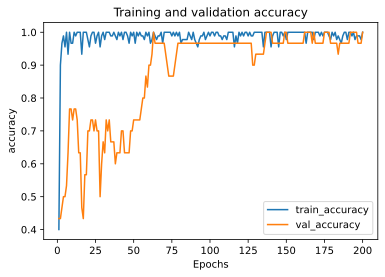

In [17]:
plot_metric(history, 'accuracy')

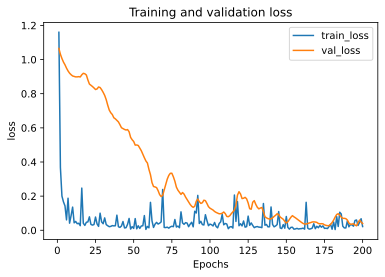

In [18]:
plot_metric(history, 'loss')

In [19]:
# Evaluate the model on the test set
model.evaluate(X_test, y_test, verbose=2)

30/1 - 0s - loss: 0.1103 - accuracy: 0.9667


[0.1103389710187912, 0.96666664]

## That's it

Thanks for reading

This is a notebook for the medium article [Batch Normalization in practice: an example with Keras and TensorFlow 2.0](https://medium.com/@bindiatwork/batch-normalization-in-practice-an-example-with-keras-and-tensorflow-2-0-b1ec28bde96f)

Please check out article for instructions